# <img align="left" src="img/ECE364-logo.png" width="300px" style="padding:30px;border:thin solid white;"> 

# Lecture 10 - Multi-class logistic regression
## ECE364 - Programming Methods for Machine Learning
### Nickvash Kani 













###### Slides based off prior lectures by Alex Schwing, Aigou Han, Farzad Kamalabadi, Corey Snyder. All mistakes are my own!

Things we'll discuss in this lecture: 

- Binary cost functions
    - Linear 
    - Logistic squared-error
    - Logistic cross-entropy
- Multi-class classification

## Binary loss(cost) functions

Let's review the regression models we've investigated so far. 

Some definitions: 

- Dataset ${\cal D} = \{(x^{(i)}, y^{(i)}\}$
- Labels: $t^{(i)}\in\{0, 1, \dots, C-1\}$. 
     - For binary classification, there are only two labels ($t^{(i)} \in \{ 0, 1\}$)

How can we learn a classifier to deal with this?

### Linear Regression

Linear regression is the simplest model to fit (and even has exact solution(s)!). Can we use that: 

$$
y = \mathbf{w}^\mathsf{T} \mathbf{x} + b
$$

$$
\mathcal{L}_{SE}(y, t) = \tfrac{1}{2} (y - t)^2
$$

- Doesn't matter that the targets are actually binary.
- Threshold predictions at \(y = 1/2\).

#### The problem 

<img align="center" src="img/lin_reg_problem.png" width="600px" style="padding:30px;border:thin solid white;"> 

linear regression hates when a prediction is made with a high degree of confidence. 

### Logistic Function 

- No reason to predict values outside [0, 1]. Let's squash $y$ into this interval.

- The logistic function is a kind of sigmoidal, or S-shaped, function:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

- A linear model with a logistic nonlinearity is known as **log-linear**:

$$
z = \mathbf{w}^\mathsf{T}\mathbf{x} + b
$$

$$
y = \sigma(z)
$$

$$
\mathcal{L}_{SE}(y, t) = \tfrac{1}{2} (y - t)^2
$$

- Used in this way, $\sigma$ is called an **activation function**, and $z$ is called the **logit**.

[1]

#### The problem

<img align="center" src="img/log_mse_loss_plot.png" width="800px" style="padding:30px;border:thin solid white;"> 

- In gradient descent, a small gradient implies a small step should be taken.

- But if the prediction is very wrong, shouldn't a large step be taken? 

- We say the learning algorithm does not have a strong **gradient signal**

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Logistic (sigmoid) function
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

# Squared-error loss for one sample with label t=1:
# L(z) = 0.5 * (sigmoid(z) - 1)^2
def squared_error_loss(z, t=1.0):
    return 0.5 * (sigmoid(z) - t)**2

# Derivative of L(z) w.r.t. z
# dL/dz = (sigmoid(z) - t) * sigmoid(z) * (1 - sigmoid(z))
def dL_dz(z, t=1.0):
    s = sigmoid(z)
    return (s - t) * s * (1 - s)

# Create a range of z-values
z_values = np.linspace(-10, 5, 400)

# Compute the squared-error loss for each z
L_values = squared_error_loss(z_values)

# Plot the squared-error loss
plt.figure(figsize=(7,5))
plt.plot(z_values, L_values, 'b', label='Squared Error Loss')

# Mark vertical line at z=0 for reference (optional)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)

# Plot tangent lines at z = -6, -4, -2
for z0 in [-6, -4, -2]:
    L0 = squared_error_loss(z0)
    slope = dL_dz(z0)
    
    # We'll plot the tangent line in some neighborhood around z0
    z_tangent = np.linspace(z0 - 2, z0 + 2, 50)
    L_tangent = L0 + slope * (z_tangent - z0)
    
    plt.plot(z_tangent, L_tangent, 'r', alpha=0.8)
    plt.scatter(z0, L0, color='red')  # highlight the point of tangency

# Set axis limits and labels
plt.xlim([-10, 5])
plt.ylim([-0.1, 0.6])
plt.xlabel('z')
plt.ylabel('Loss')
plt.title('Squared-Error Loss for Logistic Function (t=1)')
plt.legend()
plt.grid(True, alpha=0.3)
#plt.show()
plt.savefig("img/log_mse_loss_plot.png")

### Cross-entropy loss

- Because $y \in [0, 1]$, we can interpret it as the estimated probability that $t = 1$.

- The pundits who were 99% confident Clinton would win were much more wrong than the ones who were only 90% confident.

- **Cross-entropy loss** captures this intuition:

$$
z = w^Tx+b
$$

$$
\begin{align}
    y &= \sigma(z)\\
      &= \frac{1}{1+e^{-z}}
\end{align}
$$

$$
\mathcal{L}_{CE}(y, t) = 
\begin{cases}
-\log y, & \text{if } t = 1,\\
-\log (1 - y), & \text{if } t = 0,
\end{cases}
$$

which can also be written as

$$
\mathcal{L}_{CE}(y, t) 
= -\,t \,\log y \;-\; (1 - t)\,\log\bigl(1 - y\bigr).
$$


<img align="center" src="img/log_ce_loss_plot.png" width="600px" style="padding:30px;border:thin solid white;"> 



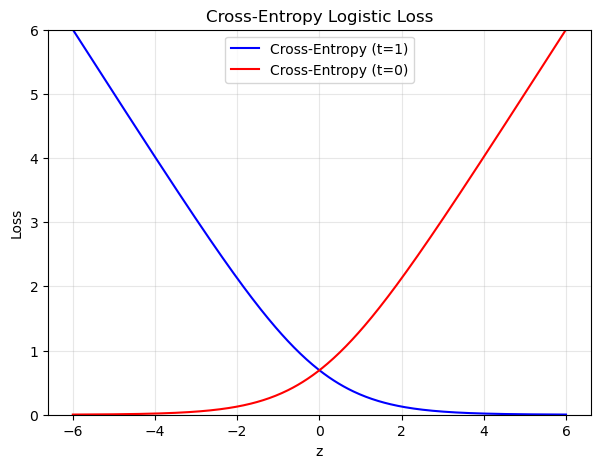

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Cross-entropy loss for a single sample, label t in {0,1}:
def cross_entropy_loss(z, t):
    s = sigmoid(z)
    # Add a tiny epsilon to avoid log(0) if desired
    epsilon = 1e-15
    s = np.clip(s, epsilon, 1 - epsilon)
    return - (t * np.log(s) + (1 - t) * np.log(1 - s))

# Create a range of z-values
z_values = np.linspace(-6, 6, 400)

# Compute CE loss for t=1 and t=0
L_pos = cross_entropy_loss(z_values, t=1)
L_neg = cross_entropy_loss(z_values, t=0)

# Plot both on the same figure
plt.figure(figsize=(7,5))
plt.plot(z_values, L_pos, 'b', label='Cross-Entropy (t=1)')
plt.plot(z_values, L_neg, 'r', label='Cross-Entropy (t=0)')

# Axis labels, legend, grid, etc.
plt.xlabel('z')
plt.ylabel('Loss')
plt.title('Cross-Entropy Logistic Loss')
plt.grid(True, alpha=0.3)
plt.legend()
plt.ylim([0, 6])  # Adjust as needed
#plt.show()
plt.savefig("img/log_ce_loss_plot.png")

## Multi-class regression

OK so we've exhausted binary classification. But maany classifications are no binary: 

- Animal species
- Car manufacturers/models 
- Final grade

So what do we do when we have inputs that have more than two classification classes? 

### Reduction to binary classification (one vs rest)

If we insist on using binary classifiers, we are not absent options:  

<img align="center" src="img/one_vs_all.png" width="600px" style="padding:30px;border:thin solid white;"> 

Strategy: Train three classifiers with $y \in [0,1]$ where each classifier considers another class as the positive class. 

We then get three classification models:

- $f_1 (x; w)$ for classifying triangles
- $f_2 (x; w)$ for classifying x's
- $f_3 (x; w)$ for classifying circles

Final predictions: $\arg\max_k f_k(x,w)$




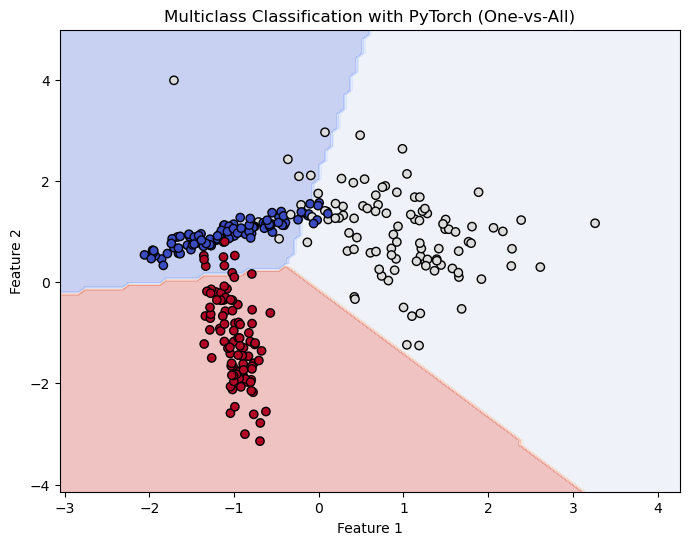

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Generate a synthetic dataset with three classes
X, y = make_classification(n_samples=300, n_features=2, n_classes=3, n_clusters_per_class=1, n_redundant=0, random_state=42)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define a simple logistic regression model
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.linear = nn.Linear(2, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))  # Sigmoid for binary classification

# Train three classifiers (one vs all)
models = []
for class_idx in range(3):
    model = BinaryClassifier()
    criterion = nn.BCELoss()  # Binary cross-entropy loss
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    
    # Convert labels to binary (1 for the class, 0 for others)
    y_binary = (y_train_tensor == class_idx).float().unsqueeze(1)
    
    # Train the model
    for epoch in range(1000):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_binary)
        loss.backward()
        optimizer.step()
    
    models.append(model)

# Plot the decision boundaries
xx, yy = np.meshgrid(np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100),
                     np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)

# Get predictions from all models
predictions = np.zeros((grid.shape[0], 3))
for class_idx, model in enumerate(models):
    predictions[:, class_idx] = model(grid_tensor).detach().numpy().ravel()

# Assign each point to the class with the highest probability
final_predictions = np.argmax(predictions, axis=1)
final_predictions = final_predictions.reshape(xx.shape)

# Plot results
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, final_predictions, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", cmap=plt.cm.coolwarm)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Multiclass Classification with PyTorch (One-vs-All)")
plt.show()


### Multi-class regression

What if there are 1000 classes? Going through a whole bunch of effort to reuse some old binary classification code kinda negates the time savings by using the old code in the first place.... 

Let's regain some footing. What do we know? 


Recall the sigmoid function is defined as

$$
\sigma(z) = \frac{1}{1 + e^{-z}},
$$

where $z \in \mathbb{R}$. The function $\sigma(z)$ maps any real value $z$ to a number in the interval $(0,1)$ and is a monotonically increasing function.

The probability is thus represented by

$$
P(y \mid x) =
\begin{cases}
\sigma\bigl(w^\mathsf{T} x\bigr), & \text{if } y = +1,\\
1 - \sigma\bigl(w^\mathsf{T} x\bigr), & \text{if } y = -1,
\end{cases}
$$

which can also be written as

$$
P(y \mid x) = \sigma\bigl(y \cdot w^\mathsf{T} x\bigr),
$$

due to the fact that $\theta(-z) = 1 - \theta(z)$. Note that in the binary case, we only need to estimate one probability, because $P(y = +1 \mid x)$ and $P(y = -1 \mid x)$ sum to 1.

[2]

But that is for binary classes. What do we need to satisfy for multiple classes: 

- non-negativity: $p(Y=y|x) \geq 0$ $\forall y\in\{0, \dots, C-1\}$
- sum to one: $\sum_{y\in\{0, \dots, C-1\}} p(Y=y|x) = 1$

What kind of function can satisfy these constraints? 

Well if a single logistic fuction is of the form: 

$$
\sigma(z) = \frac{e^z}{1 + e^z} \;=\; \frac{1}{1 + e^{-z}},
$$

maybe we can add the probabilities together to get:

$$
\text{softmax}(\mathbf{v}) 
= 
\frac{1}{\sum_{c=0}^{C-1} e^{v_c}}
\begin{bmatrix}
e^{v_0} \\[6pt]
e^{v_1} \\[6pt]
\vdots  \\[6pt]
e^{v_{C-1}}
\end{bmatrix}.
$$

This is referred to as the softmax function. Using the softmax function we can define the probability that $x$ belongs to a particular class $c$ as: 

$$p(Y=t|x) = \frac{\exp(w_t^Tx)}{\sum_{y\in\{0, \dots, C-1\}} \exp(w_{y}^Tx)}$$

The inputs $w^Tx$ are called **logits**.

- Note: every class has its own weight vector $w_y$


Let's train a model using this probabilistic model and let's study the result to see whether this makes sense

Example data:

In [133]:
import torch
x0 = torch.cat([torch.randn((100,))-1,torch.randn((100,))+1,torch.randn((100,))+3],dim=0)
y = torch.cat([torch.zeros((100,),dtype=torch.int8),torch.ones((100,),dtype=torch.int8),2*torch.ones((100,),dtype=torch.int8)],dim=0)

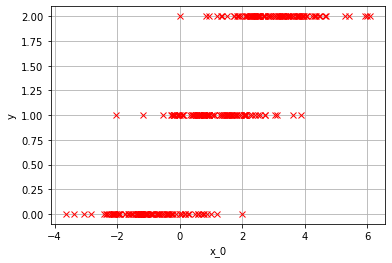

In [134]:
import matplotlib.pyplot as plt
plt.plot(x0,y,'rx')
plt.grid(True)
plt.xlabel('x_0')
plt.ylabel('y')
plt.show()

How did we train a model again?

Maximum-likelihood or minimizing the negative log-likelihood:

$$ loss(x,t; w) = \min_w \sum_{(x^{(i)},t^{(i)})\in{\cal D}} -\log p(t|x)$$

Let's plug our probability model in there and see what happens:

$$
\begin{align}
loss(x,t; w) &= \min_w \sum_{(x^{(i)},t^{(i)})\in{\cal D}} -\log p(t|x)\\
&= \min_w \sum_{(x^{(i)},t^{(i)})\in{\cal D}} -\log\frac{\exp(w_t^Tx)}{\sum_{c\in\{0, \dots, C-1\}} \exp(w_{c}^Tx)}\\
&= \min_w \sum_{(x^{(i)},t^{(i)})\in{\cal D}} -\left(\log \exp(w_t^Tx) - \log \sum_{c\in\{0, \dots, C-1\}} \exp(w_{c}^Tx) \right)\\
&=\min_w \sum_{(x^{(i)},t^{(i)})\in{\cal D}} \left(- w_{t^{(i)}}^Tx + \log\sum_{c\in\{0, \dots, C-1\}} \exp(w_{c}^Tx)\right)
\end{align}
$$

How to efficiently implement this objective function? Let's put the weight vectors for each class into a matrix

$$W = \left[\begin{array}{ccc}\vdots&&\vdots\\w_0&\dots&w_{C-1}\\\vdots&&\vdots\end{array}\right]\in\mathbb{R}^{D\times C}$$

In [135]:
W0 = torch.randn((2,3))

In [136]:
X = torch.cat([x0.unsqueeze(0), torch.ones_like(x0).unsqueeze(0)],dim=0)
def objfun(X,y,W):
    #res1 = (W[:,y.to(torch.long)]*X).sum(dim=0)
    logits = W.t()@X
    firstterm = -torch.gather(logits,dim=0,index=y.view(1,-1).to(torch.int64))
    secondterm = torch.logsumexp(logits,dim=0,keepdim=True)
    return torch.mean(firstterm+secondterm)
objfun(X,y,W0)

tensor(2.5278)

In [137]:
w = W0.clone()
w.requires_grad = True
alpha = 1.0
numIter = 200
funs = torch.zeros((numIter,1))
optimizer = torch.optim.SGD([w],lr=alpha,momentum=0,dampening=0,weight_decay=0)
for iter in range(numIter):
    optimizer.zero_grad()
    f = objfun(X,y,w)
    f.backward()
    optimizer.step()
    funs[iter] = f.item()

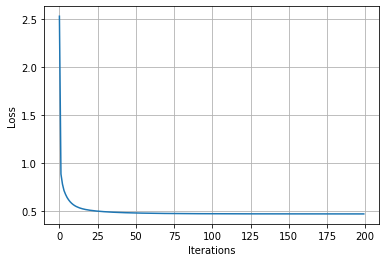

In [138]:
plt.plot(range(numIter),funs)
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

What's our $W$ matrix now?

In [139]:
print(w)

tensor([[-2.8949, -0.8160,  1.0344],
        [ 1.4525,  1.3690, -2.4531]], requires_grad=True)


How do we check that this makes sense?

Note that we can't plot the loss function in parameter space anymore. Why?

We have 6 parameters, i.e., 6-dimensional space. Hard to plot.

But we can plot the probabilities: $$p(Y=t|x) = \frac{\exp(w_t^Tx)}{\sum_{y\in\{0, \dots, C-1\}} \exp(w_{y}^Tx)}$$

In [140]:
xaxis = torch.linspace(-5,5,100)
Xxaxis = torch.cat([xaxis.unsqueeze(0),torch.ones_like(xaxis).unsqueeze(0)],dim=0)
logits = w.detach().t()@Xxaxis
probs = torch.nn.functional.softmax(logits,dim=0)
print(probs.shape)

torch.Size([3, 100])


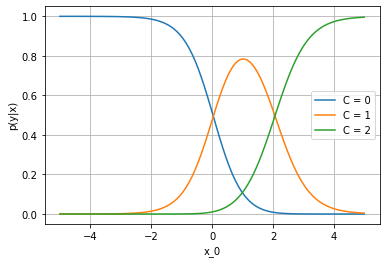

In [141]:
plt.plot(xaxis,probs.t())
plt.grid(True)
plt.xlabel('x_0')
plt.ylabel('p(y|x)')
plt.legend(['C = 0','C = 1','C = 2'])
plt.show()

Seems reasonable.

Can we avoid some of the code above? I.e., can we compress this more and use more pytorch code?

Pytorch's ```torch.CrossEntropyLoss``` (https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) looks very similar to what we need:

The loss can be described as:

$$
\text{loss}(x, \text{class}) 
= 
-\log \!\Bigl(\frac{\exp\bigl(x[\text{class}]\bigr)}{\sum_j \exp\bigl(x[j]\bigr)}\Bigr).
$$

How can we use this one? What do we need?

In [144]:
def LinearNetFun(X,W):
    logits = W.t()@X
    return logits.t()

In [145]:
w = W0.clone()
w.requires_grad = True
alpha = 1.0
numIter = 200
funs = torch.zeros((numIter,1))
optimizer = torch.optim.SGD([w],lr=alpha,momentum=0,dampening=0,weight_decay=0)
loss = torch.nn.CrossEntropyLoss()
ylong = y.to(torch.long)
for iter in range(numIter):
    optimizer.zero_grad()
    f = loss(LinearNetFun(X,w),ylong)
    f.backward()
    optimizer.step()
    funs[iter] = f.item()

In [146]:
print(w)

tensor([[-2.8949, -0.8160,  1.0344],
        [ 1.4525,  1.3690, -2.4531]], requires_grad=True)


Same result as before. Very nice. Looks like we used ```torch.CrossEntropyLoss``` the right way.

Weights shouldn't be defined anywhere in the code. Let's clean this up a little more.

Recall the plotting of composite functions from Lecture 4. Let's use the same syntax

In [147]:
class OurNet(torch.nn.Module):
    def __init__(self):
        super(OurNet,self).__init__()
        self.fc1 = torch.nn.Linear(2,3,bias=False)
    def forward(self,x):
        return self.fc1(x.t())
net1 = OurNet()

In [148]:
net1.fc1.weight.data = W0.t().data.clone()

In [149]:
alpha = 1.0
numIter = 200
funs = torch.zeros((numIter,1))
optimizer = torch.optim.SGD(net1.parameters(),lr=alpha,momentum=0,dampening=0,weight_decay=0)
loss = torch.nn.CrossEntropyLoss()
ylong = y.to(torch.long)
for iter in range(numIter):
    optimizer.zero_grad()
    f = loss(net1(X),ylong)
    f.backward()
    optimizer.step()
    funs[iter] = f.item()

In [150]:
print(net1.fc1.weight)

Parameter containing:
tensor([[-2.8949,  1.4525],
        [-0.8160,  1.3690],
        [ 1.0344, -2.4531]], requires_grad=True)


Same result again. Very nice, this is starting to look clean now.

But wait, why do we manually append our data with ones? Isn't that wasteful? Can we avoid this?

In [165]:
class OurNet2(torch.nn.Module):
    def __init__(self):
        super(OurNet2,self).__init__()
        self.fc1 = torch.nn.Linear(1,3,bias=True)
    def forward(self,x):
        return self.fc1(x)
net2 = OurNet2()

In [166]:
net2.fc1.weight.data = W0[0,:].view(-1,1).data.clone()
net2.fc1.bias.data = W0[1,:].view(-1).data.clone()

In [167]:
alpha = 1.0
numIter = 200
funs = torch.zeros((numIter,1))
optimizer = torch.optim.SGD(net2.parameters(),lr=alpha,momentum=0,dampening=0,weight_decay=0)
loss = torch.nn.CrossEntropyLoss()
ylong = y.to(torch.long)
for iter in range(numIter):
    optimizer.zero_grad()
    f = loss(net2(x0.view(-1,1)),ylong)
    f.backward()
    optimizer.step()
    funs[iter] = f.item()

In [168]:
print(net2.fc1.weight)
print(net2.fc1.bias)

Parameter containing:
tensor([[-2.8949],
        [-0.8160],
        [ 1.0344]], requires_grad=True)
Parameter containing:
tensor([ 1.4525,  1.3690, -2.4531], requires_grad=True)


## That's it for today

- Next time we'll explore the torch.nn library. 
    - It will make our lives easier when we go onto more advanced neural networks!

## References

[1] Roger Grosse CSC321 lectures - https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/

[2] Shuiwang Ji Notes, "Logistic Regression: From Binary to Multi-class - https://people.tamu.edu/~sji/classes/LR.pdf